In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/ML/')

In [3]:
import warnings
warnings.simplefilter('ignore') # 忽略所有的警告信息

import os # 提供与操作系统交互的函数
import gc # 垃圾回收模块

import numpy as np # 数值计算库
import pandas as pd # 数据处理和分析库
pd.set_option('display.max_columns', None) #将 Pandas DataFrame 中的列数显示设置为无限制
from tqdm.auto import tqdm # 用于在循环中显示进度条

from sklearn.preprocessing import LabelEncoder # 用于将分类特征转换为整数标签
from sklearn.metrics import mean_squared_log_error # 均方对数误差

import lightgbm as lgb # 牛逼哄哄的LightGBM模型
from lightgbm import log_evaluation, early_stopping

from matplotlib.pyplot import plot, show # 用于绘制、显示图表

In [4]:
# 玩家角色表

# 使用 Pandas 读取了名为role_id.csv的文件，并将其存储在名为roles的DataFrame中
# DataFrame是一种类似于数据库表的数据结构
roles = pd.read_csv('datasets/role_id.csv')

# 共七天, roles 表填充完整
dfs = [] # 创建一个空列表dfs
for i in range(2, 9):
    tmp = roles.copy() #复制名为roles的DataFrame, 以确保在操作tmp时不会修改原始的roles DataFrame
    tmp['day'] = i # tmp['day'] = i：在临时DataFrame tmp 中添加一个名为day的列，赋值为当前循环的i值
    dfs.append(tmp) # 将处理后的临时DataFrame tmp 添加到dfs列表中
# 使用pd.concat()函数将dfs列表中的所有DataFrame连接起来，形成一个新的DataFrame data
# pd.concat()函数用于沿着指定轴（默认为行方向）将多个DataFrame连接在一起。reset_index(drop=True)用于重置data DataFrame 的索引，并丢弃之前的索引，生成一个新的连续整数索引。
data = pd.concat(dfs).reset_index(drop=True)
data

# [question]: 为什么要重复拷贝role_id到每一天

,role_id,create_time,day
0,28b9114a5784b724997257c3,1593268403,2
1,51d43143f0e8c695792ee1d4,1613439868,2
2,52f2bb2665cdb5d81dd245ba,1612927043,2
3,1f3c325b343a3f56b898265e,1614044315,2
4,76d3a7bd0a8ed2b011a99aae,1614056679,2
...,...,...,...
75455,f0f80e12dfa091b5fba71de0,1609603813,8
75456,1cae51d9bd791f6337d1e612,1615136565,8
75457,e6170ea5237741839701d6e6,1615202540,8
75458,42713418593ef32b3f65cc03,1584760818,8


In [5]:
# 货币消耗表
consume = pd.read_csv('datasets/role_consume_op.csv')
consume['dt'] = pd.to_datetime(consume['dt']) # pd.to_datetime()函数用于将列中的数据从字符串格式转换为日期时间格式
consume['day'] = consume['dt'].dt.day # .day表示提取日期时间对象中的天数部分

# 货币消耗按天合并
# TODO: mtime 可以做时差衍生特征, 其他表也是一样的
for i in range(1, 5):
    for m in ['count', 'sum']:
        # 利用groupby()函数对consume DataFrame进行分组，按照role_id和day列进行分组
        # 针对列名为use_t{i}的列进行聚合操作，agg()函数用于对分组后的数据进行其参数指定的聚合操作
        # to_frame()将结果转换为DataFrame，并指定列名为use_t{i}_day_{m}
        # reset_index()重新设置索引
        tmp = consume.groupby(['role_id', 'day'])[f'use_t{i}'].agg(m).to_frame(name=f'use_t{i}_day_{m}').reset_index()
        # 将得到的临时DataFrame tmp与data DataFrame进行左连接（left join），依据role_id和day列进行连接
        # 对比下面的表格和上面的表格可以看出是什么效果
        data = data.merge(tmp, on=['role_id', 'day'], how='left')

data

,role_id,create_time,day,use_t1_day_count,use_t1_day_sum,use_t2_day_count,use_t2_day_sum,use_t3_day_count,use_t3_day_sum,use_t4_day_count,use_t4_day_sum
0,28b9114a5784b724997257c3,1593268403,2,1.0,-398.0,1.0,0.0,1.0,0.0,1.0,0.0
1,51d43143f0e8c695792ee1d4,1613439868,2,31.0,135.0,31.0,0.0,31.0,0.0,31.0,0.0
2,52f2bb2665cdb5d81dd245ba,1612927043,2,5.0,-1464.0,5.0,0.0,5.0,0.0,5.0,0.0
3,1f3c325b343a3f56b898265e,1614044315,2,12.0,-20.0,12.0,0.0,12.0,0.0,12.0,0.0
4,76d3a7bd0a8ed2b011a99aae,1614056679,2,5.0,-140.0,5.0,0.0,5.0,0.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
75455,f0f80e12dfa091b5fba71de0,1609603813,8,14.0,31.0,14.0,0.0,14.0,0.0,14.0,0.0
75456,1cae51d9bd791f6337d1e612,1615136565,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75457,e6170ea5237741839701d6e6,1615202540,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75458,42713418593ef32b3f65cc03,1584760818,8,1.0,-10.0,1.0,0.0,1.0,0.0,1.0,0.0


In [6]:
# 升级表

evolve = pd.read_csv('datasets/role_evolve_op.csv')
evolve['dt'] = pd.to_datetime(evolve['dt'])
evolve['day'] = evolve['dt'].dt.day
evolve['n_level_up'] = evolve['new_lv'] - evolve['old_lv']
evolve = evolve.rename(columns={'num': 'lv_consume_item_num'}) # num: 消耗了多少道具

for col in ['type', 'item_id']:
    for m in ['count', 'nunique']: # nunique 是 Pandas 中用于计算唯一值数量的聚合函数
        tmp = evolve.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')
for col in ['lv_consume_item_num', 'n_level_up']:
    for m in ['sum', 'mean']:
        tmp = evolve.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')

data

,role_id,create_time,day,use_t1_day_count,use_t1_day_sum,use_t2_day_count,use_t2_day_sum,use_t3_day_count,use_t3_day_sum,use_t4_day_count,use_t4_day_sum,type_day_count,type_day_nunique,item_id_day_count,item_id_day_nunique,lv_consume_item_num_day_sum,lv_consume_item_num_day_mean,n_level_up_day_sum,n_level_up_day_mean
0,28b9114a5784b724997257c3,1593268403,2,1.0,-398.0,1.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51d43143f0e8c695792ee1d4,1613439868,2,31.0,135.0,31.0,0.0,31.0,0.0,31.0,0.0,49.0,2.0,49.0,4.0,49.0,1.000000,6.0,0.122449
2,52f2bb2665cdb5d81dd245ba,1612927043,2,5.0,-1464.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0,1.0,5.0,1.0,5.0,1.000000,4.0,0.800000
3,1f3c325b343a3f56b898265e,1614044315,2,12.0,-20.0,12.0,0.0,12.0,0.0,12.0,0.0,40.0,2.0,40.0,5.0,40.0,1.000000,15.0,0.375000
4,76d3a7bd0a8ed2b011a99aae,1614056679,2,5.0,-140.0,5.0,0.0,5.0,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75455,f0f80e12dfa091b5fba71de0,1609603813,8,14.0,31.0,14.0,0.0,14.0,0.0,14.0,0.0,32.0,2.0,32.0,2.0,37.0,1.156250,2.0,0.062500
75456,1cae51d9bd791f6337d1e612,1615136565,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75457,e6170ea5237741839701d6e6,1615202540,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75458,42713418593ef32b3f65cc03,1584760818,8,1.0,-10.0,1.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# 副本表
# TODO: 这个表信息比较多, 可以多挖掘

fb = pd.read_csv('datasets/role_fb_op.csv')
fb['dt'] = pd.to_datetime(fb['dt'])
fb['day'] = fb['dt'].dt.day
fb['fb_used_time'] = fb['finish_time'] - fb['start_time']

for col in ['fb_id', 'fb_type']:
    for m in ['count', 'nunique']:
        tmp = fb.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')
for col in ['fb_used_time', 'exp']:
    for m in ['sum', 'mean']:
        tmp = fb.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')

# value_counts() 是 Pandas 中的一个函数，用于统计一个 Series 中每个不同值的出现次数，并返回一个包含值和对应计数的 Series
# reset_index(name='fb_result_count') 的作用是将之前的索引列转换为 DataFrame 的一列，并将这一列的列名设置为 'fb_result_count'
tmp = fb.groupby(['role_id', 'day'])['fb_result'].value_counts().reset_index(name='fb_result_count')
for i in [0, 1, 2]:
    tt = tmp[tmp['fb_result'] == i] # tmp['fb_result'] == i 是一个条件筛选操作，用于选取 DataFrame 中满足条件的行
    tt.columns = list(tt.columns[:-1]) + ['fb_result%d_count'%i] # 修改 tt DataFrame 中最后一列的列名，将其命名为 fb_result%d_count'%i
    data = data.merge(tt[['role_id', 'day', 'fb_result%d_count'%i]], on=['role_id', 'day'], how='left')


In [8]:
# 任务系统表

mission = pd.read_csv('datasets/role_mission_op.csv')
mission['dt'] = pd.to_datetime(mission['dt'])
mission['day'] = mission['dt'].dt.day

for col in ['mission_id', 'mission_type']:
    for m in ['count', 'nunique']:
        tmp = mission.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')

data

,role_id,create_time,day,use_t1_day_count,use_t1_day_sum,use_t2_day_count,use_t2_day_sum,use_t3_day_count,use_t3_day_sum,use_t4_day_count,use_t4_day_sum,type_day_count,type_day_nunique,item_id_day_count,item_id_day_nunique,lv_consume_item_num_day_sum,lv_consume_item_num_day_mean,n_level_up_day_sum,n_level_up_day_mean,fb_id_day_count,fb_id_day_nunique,fb_type_day_count,fb_type_day_nunique,fb_used_time_day_sum,fb_used_time_day_mean,exp_day_sum,exp_day_mean,fb_result0_count,fb_result1_count,fb_result2_count,mission_id_day_count,mission_id_day_nunique,mission_type_day_count,mission_type_day_nunique
0,28b9114a5784b724997257c3,1593268403,2,1.0,-398.0,1.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51d43143f0e8c695792ee1d4,1613439868,2,31.0,135.0,31.0,0.0,31.0,0.0,31.0,0.0,49.0,2.0,49.0,4.0,49.0,1.000000,6.0,0.122449,6.0,4.0,6.0,1.0,707.0,117.833333,1.366090e+08,2.276817e+07,3.0,3.0,NaN,NaN,NaN,NaN,NaN
2,52f2bb2665cdb5d81dd245ba,1612927043,2,5.0,-1464.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0,1.0,5.0,1.0,5.0,1.000000,4.0,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,9.0,23.0,2.0
3,1f3c325b343a3f56b898265e,1614044315,2,12.0,-20.0,12.0,0.0,12.0,0.0,12.0,0.0,40.0,2.0,40.0,5.0,40.0,1.000000,15.0,0.375000,3.0,3.0,3.0,2.0,207.0,69.000000,1.729617e+08,5.765390e+07,1.0,2.0,NaN,NaN,NaN,NaN,NaN
4,76d3a7bd0a8ed2b011a99aae,1614056679,2,5.0,-140.0,5.0,0.0,5.0,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,4.0,10.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75455,f0f80e12dfa091b5fba71de0,1609603813,8,14.0,31.0,14.0,0.0,14.0,0.0,14.0,0.0,32.0,2.0,32.0,2.0,37.0,1.156250,2.0,0.062500,3.0,2.0,3.0,1.0,84.0,28.000000,1.702063e+11,5.673544e+10,1.0,2.0,NaN,8.0,4.0,8.0,4.0
75456,1cae51d9bd791f6337d1e612,1615136565,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0,12.0,39.0,1.0
75457,e6170ea5237741839701d6e6,1615202540,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,1.0,61.0,30.500000,0.000000e+00,0.000000e+00,NaN,2.0,NaN,112.0,33.0,112.0,2.0
75458,42713418593ef32b3f65cc03,1584760818,8,1.0,-10.0,1.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,124.0,124.000000,0.000000e+00,0.000000e+00,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# 玩家离线表
# TODO: 可以做很多时间、坐标方面的特征

offline = pd.read_csv('datasets/role_offline_op.csv')
offline['dt'] = pd.to_datetime(mission['dt'])
offline['day'] = offline['dt'].dt.day
offline['online_durations'] = offline['offline'] - offline['online']

for col in ['reason', 'map_id']:
    for m in ['count', 'nunique']:
        tmp = offline.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')

for col in ['online_durations']:
    for m in ['mean', 'sum']:
        tmp = offline.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')

data

,role_id,create_time,day,use_t1_day_count,use_t1_day_sum,use_t2_day_count,use_t2_day_sum,use_t3_day_count,use_t3_day_sum,use_t4_day_count,use_t4_day_sum,type_day_count,type_day_nunique,item_id_day_count,item_id_day_nunique,lv_consume_item_num_day_sum,lv_consume_item_num_day_mean,n_level_up_day_sum,n_level_up_day_mean,fb_id_day_count,fb_id_day_nunique,fb_type_day_count,fb_type_day_nunique,fb_used_time_day_sum,fb_used_time_day_mean,exp_day_sum,exp_day_mean,fb_result0_count,fb_result1_count,fb_result2_count,mission_id_day_count,mission_id_day_nunique,mission_type_day_count,mission_type_day_nunique,reason_day_count,reason_day_nunique,map_id_day_count,map_id_day_nunique,online_durations_day_mean,online_durations_day_sum
0,28b9114a5784b724997257c3,1593268403,2,1.0,-398.0,1.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,1.0,352.500000,705.0
1,51d43143f0e8c695792ee1d4,1613439868,2,31.0,135.0,31.0,0.0,31.0,0.0,31.0,0.0,49.0,2.0,49.0,4.0,49.0,1.000000,6.0,0.122449,6.0,4.0,6.0,1.0,707.0,117.833333,1.366090e+08,2.276817e+07,3.0,3.0,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,1337.333333,4012.0
2,52f2bb2665cdb5d81dd245ba,1612927043,2,5.0,-1464.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0,1.0,5.0,1.0,5.0,1.000000,4.0,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,9.0,23.0,2.0,3.0,2.0,3.0,1.0,269.666667,809.0
3,1f3c325b343a3f56b898265e,1614044315,2,12.0,-20.0,12.0,0.0,12.0,0.0,12.0,0.0,40.0,2.0,40.0,5.0,40.0,1.000000,15.0,0.375000,3.0,3.0,3.0,2.0,207.0,69.000000,1.729617e+08,5.765390e+07,1.0,2.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,2.0,344.500000,689.0
4,76d3a7bd0a8ed2b011a99aae,1614056679,2,5.0,-140.0,5.0,0.0,5.0,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,4.0,10.0,1.0,1.0,1.0,1.0,1.0,100.000000,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75455,f0f80e12dfa091b5fba71de0,1609603813,8,14.0,31.0,14.0,0.0,14.0,0.0,14.0,0.0,32.0,2.0,32.0,2.0,37.0,1.156250,2.0,0.062500,3.0,2.0,3.0,1.0,84.0,28.000000,1.702063e+11,5.673544e+10,1.0,2.0,NaN,8.0,4.0,8.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
75456,1cae51d9bd791f6337d1e612,1615136565,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0,12.0,39.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
75457,e6170ea5237741839701d6e6,1615202540,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,1.0,61.0,30.500000,0.000000e+00,0.000000e+00,NaN,2.0,NaN,112.0,33.0,112.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
75458,42713418593ef32b3f65cc03,1584760818,8,1.0,-10.0,1.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,124.0,124.000000,0.000000e+00,0.000000e+00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# 付费表

pay = pd.read_csv('datasets/role_pay.csv')
pay['dt'] = pd.to_datetime(pay['dt'])
pay['day'] = pay['dt'].dt.day
tmp = pay.groupby(['role_id', 'day'])['pay'].agg('sum').to_frame(name='pay_sum_day').reset_index()
data = data.merge(tmp, on=['role_id', 'day'], how='left')
data['pay_sum_day'].fillna(0., inplace=True)

data

,role_id,create_time,day,use_t1_day_count,use_t1_day_sum,use_t2_day_count,use_t2_day_sum,use_t3_day_count,use_t3_day_sum,use_t4_day_count,use_t4_day_sum,type_day_count,type_day_nunique,item_id_day_count,item_id_day_nunique,lv_consume_item_num_day_sum,lv_consume_item_num_day_mean,n_level_up_day_sum,n_level_up_day_mean,fb_id_day_count,fb_id_day_nunique,fb_type_day_count,fb_type_day_nunique,fb_used_time_day_sum,fb_used_time_day_mean,exp_day_sum,exp_day_mean,fb_result0_count,fb_result1_count,fb_result2_count,mission_id_day_count,mission_id_day_nunique,mission_type_day_count,mission_type_day_nunique,reason_day_count,reason_day_nunique,map_id_day_count,map_id_day_nunique,online_durations_day_mean,online_durations_day_sum,pay_sum_day
0,28b9114a5784b724997257c3,1593268403,2,1.0,-398.0,1.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,1.0,352.500000,705.0,0.0
1,51d43143f0e8c695792ee1d4,1613439868,2,31.0,135.0,31.0,0.0,31.0,0.0,31.0,0.0,49.0,2.0,49.0,4.0,49.0,1.000000,6.0,0.122449,6.0,4.0,6.0,1.0,707.0,117.833333,1.366090e+08,2.276817e+07,3.0,3.0,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,1337.333333,4012.0,0.0
2,52f2bb2665cdb5d81dd245ba,1612927043,2,5.0,-1464.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0,1.0,5.0,1.0,5.0,1.000000,4.0,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,9.0,23.0,2.0,3.0,2.0,3.0,1.0,269.666667,809.0,0.0
3,1f3c325b343a3f56b898265e,1614044315,2,12.0,-20.0,12.0,0.0,12.0,0.0,12.0,0.0,40.0,2.0,40.0,5.0,40.0,1.000000,15.0,0.375000,3.0,3.0,3.0,2.0,207.0,69.000000,1.729617e+08,5.765390e+07,1.0,2.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,2.0,344.500000,689.0,0.0
4,76d3a7bd0a8ed2b011a99aae,1614056679,2,5.0,-140.0,5.0,0.0,5.0,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,4.0,10.0,1.0,1.0,1.0,1.0,1.0,100.000000,100.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75455,f0f80e12dfa091b5fba71de0,1609603813,8,14.0,31.0,14.0,0.0,14.0,0.0,14.0,0.0,32.0,2.0,32.0,2.0,37.0,1.156250,2.0,0.062500,3.0,2.0,3.0,1.0,84.0,28.000000,1.702063e+11,5.673544e+10,1.0,2.0,NaN,8.0,4.0,8.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
75456,1cae51d9bd791f6337d1e612,1615136565,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0,12.0,39.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
75457,e6170ea5237741839701d6e6,1615202540,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,1.0,61.0,30.500000,0.000000e+00,0.000000e+00,NaN,2.0,NaN,112.0,33.0,112.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
75458,42713418593ef32b3f65cc03,1584760818,8,1.0,-10.0,1.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,124.0,124.000000,0.000000e+00,0.000000e+00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [11]:
data.fillna(0., inplace=True) # 缺失值填0
data

,role_id,create_time,day,use_t1_day_count,use_t1_day_sum,use_t2_day_count,use_t2_day_sum,use_t3_day_count,use_t3_day_sum,use_t4_day_count,use_t4_day_sum,type_day_count,type_day_nunique,item_id_day_count,item_id_day_nunique,lv_consume_item_num_day_sum,lv_consume_item_num_day_mean,n_level_up_day_sum,n_level_up_day_mean,fb_id_day_count,fb_id_day_nunique,fb_type_day_count,fb_type_day_nunique,fb_used_time_day_sum,fb_used_time_day_mean,exp_day_sum,exp_day_mean,fb_result0_count,fb_result1_count,fb_result2_count,mission_id_day_count,mission_id_day_nunique,mission_type_day_count,mission_type_day_nunique,reason_day_count,reason_day_nunique,map_id_day_count,map_id_day_nunique,online_durations_day_mean,online_durations_day_sum,pay_sum_day
0,28b9114a5784b724997257c3,1593268403,2,1.0,-398.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0,352.500000,705.0,0.0
1,51d43143f0e8c695792ee1d4,1613439868,2,31.0,135.0,31.0,0.0,31.0,0.0,31.0,0.0,49.0,2.0,49.0,4.0,49.0,1.000000,6.0,0.122449,6.0,4.0,6.0,1.0,707.0,117.833333,1.366090e+08,2.276817e+07,3.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,1337.333333,4012.0,0.0
2,52f2bb2665cdb5d81dd245ba,1612927043,2,5.0,-1464.0,5.0,0.0,5.0,0.0,5.0,0.0,5.0,1.0,5.0,1.0,5.0,1.000000,4.0,0.800000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,23.0,9.0,23.0,2.0,3.0,2.0,3.0,1.0,269.666667,809.0,0.0
3,1f3c325b343a3f56b898265e,1614044315,2,12.0,-20.0,12.0,0.0,12.0,0.0,12.0,0.0,40.0,2.0,40.0,5.0,40.0,1.000000,15.0,0.375000,3.0,3.0,3.0,2.0,207.0,69.000000,1.729617e+08,5.765390e+07,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,344.500000,689.0,0.0
4,76d3a7bd0a8ed2b011a99aae,1614056679,2,5.0,-140.0,5.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,10.0,4.0,10.0,1.0,1.0,1.0,1.0,1.0,100.000000,100.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75455,f0f80e12dfa091b5fba71de0,1609603813,8,14.0,31.0,14.0,0.0,14.0,0.0,14.0,0.0,32.0,2.0,32.0,2.0,37.0,1.156250,2.0,0.062500,3.0,2.0,3.0,1.0,84.0,28.000000,1.702063e+11,5.673544e+10,1.0,2.0,0.0,8.0,4.0,8.0,4.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
75456,1cae51d9bd791f6337d1e612,1615136565,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,39.0,12.0,39.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
75457,e6170ea5237741839701d6e6,1615202540,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,2.0,2.0,2.0,1.0,61.0,30.500000,0.000000e+00,0.000000e+00,0.0,2.0,0.0,112.0,33.0,112.0,2.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
75458,42713418593ef32b3f65cc03,1584760818,8,1.0,-10.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,1.0,1.0,1.0,124.0,124.000000,0.000000e+00,0.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [12]:
# 验证集设置
# 现在我们可以把问题转为用前n天的行为来预测第n+1天的付费

# 训练集 day 2,3,4,5,6 -> 标签 day 7 pay_sum
df_train = pd.DataFrame({'role_id': data.role_id.unique().tolist()})
for i, d in enumerate(range(2, 7)):
    tmp = data[data.day == d].copy().reset_index(drop=True)
    # (drop=True 参数：这个参数的默认值为 False，表示保留原始索引作为 DataFrame 的一列。但是当 drop=True 时，它会丢弃原始的索引列
    tmp.drop(['create_time', 'day'], axis=1, inplace=True)
    tmp.columns = ['role_id'] + [f'{c}_day{i}' for c in tmp.columns[1:]]
    df_train = df_train.merge(tmp, on='role_id')

# 验证集 day 3,4,5,6,7 -> 标签 day 8 pay_sum
df_valid = pd.DataFrame({'role_id': data.role_id.unique().tolist()})
for i, d in enumerate(range(3, 8)):
    tmp = data[data.day == d].copy().reset_index(drop=True)
    tmp.drop(['create_time', 'day'], axis=1, inplace=True)
    tmp.columns = ['role_id'] + [f'{c}_day{i}' for c in tmp.columns[1:]]
    df_valid = df_valid.merge(tmp, on='role_id')

# 测试集 day 4,5,6,7,8
df_test = pd.DataFrame({'role_id': data.role_id.unique().tolist()})
for i, d in enumerate(range(4, 9)):
    tmp = data[data.day == d].copy().reset_index(drop=True)
    tmp.drop(['create_time', 'day'], axis=1, inplace=True)
    tmp.columns = ['role_id'] + [f'{c}_day{i}' for c in tmp.columns[1:]]
    df_test = df_test.merge(tmp, on='role_id')


#标签构造

# 训练集 day == 7 pay_sum
# 验证集 day == 8 pay_sum

day7_pay = pay[pay.day == 7].copy().reset_index(drop=True)
tmp = day7_pay.groupby('role_id')['pay'].agg('sum').to_frame(name='pay').reset_index()
df_train = df_train.merge(tmp, on='role_id', how='left')
df_train['pay'].fillna(0., inplace=True)


day8_pay = pay[pay.day == 8].copy().reset_index(drop=True)
tmp = day8_pay.groupby('role_id')['pay'].agg('sum').to_frame(name='pay').reset_index()
df_valid = df_valid.merge(tmp, on='role_id', how='left')
df_valid['pay'].fillna(0., inplace=True)


In [13]:
df = pd.concat([df_train, df_valid, df_test]).reset_index(drop=True)

df['pay_log'] = np.log1p(df['pay'])

In [14]:
df_train = df[:len(df_train)].reset_index(drop=True)
df_valid = df[len(df_train):len(df_train)+len(df_valid)].reset_index(drop=True)
df_test = df[-len(df_test):].reset_index(drop=True)

In [15]:
params = {
    'objective': 'regression',
    'metric': {'rmse'},
    'boosting_type' : 'gbdt',
    'learning_rate': 0.05,
    'max_depth' : 12,
    'num_leaves' : 32,
    'feature_fraction' : 0.70,
    'subsample' : 0.75,
    'seed' : 114,
    'num_iterations' : 3000,
    'nthread' : -1,
    'verbose' : -1
}

features = [col for col in df_train.columns if col not in ['role_id', 'pay', 'pay_log']]
len(features)

190

Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.326372	valid_1's rmse: 0.491701
[100]	training's rmse: 0.290053	valid_1's rmse: 0.493453
Early stopping, best iteration is:
[48]	training's rmse: 0.328898	valid_1's rmse: 0.491645
                               Feature  importance  importance_gain
36       online_durations_day_sum_day0          93      1509.830688
189                   pay_sum_day_day4          58      6504.529942
155                use_t2_day_sum_day4          55       765.722388
31               reason_day_count_day0          43       351.817573
34             map_id_day_nunique_day0          38       241.847890
117                use_t2_day_sum_day3          37       178.473870
174                   exp_day_sum_day4          35       754.717623
151                   pay_sum_day_day3          34      2311.519602
152              use_t1_day_count_day4          33       494.746973
115                use_t1_day_sum_day3          31    

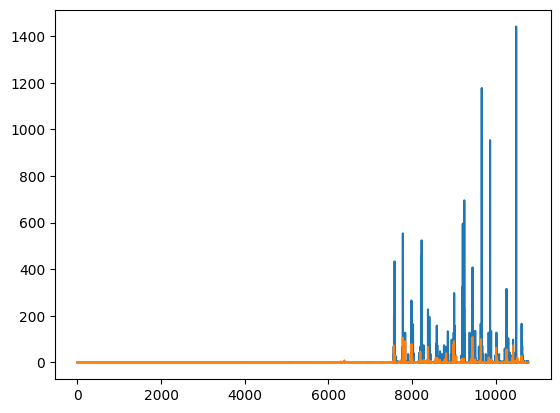

########################rmsle score 0.4915888335341229


In [16]:
def train(df_train, df_valid, label, params, features):
    '''
    训练函数
    '''
    train_label = df_train[label].values
    train_feat = df_train[features]

    valid_label = df_valid[label].values
    valid_feat = df_valid[features]
    gc.collect()

    trn_data = lgb.Dataset(train_feat, label=train_label)
    val_data = lgb.Dataset(valid_feat, label=valid_label)
    callbacks = [log_evaluation(period=50), early_stopping(stopping_rounds=100)]
    clf = lgb.train(params,
                    trn_data,
                    valid_sets=[trn_data, val_data],
                    callbacks=callbacks)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    fold_importance_df = fold_importance_df.sort_values(by='importance', ascending=False)
    print(fold_importance_df[:30])
#     fold_importance_df.to_csv(f"importance_df.csv", index=None)
    df_valid['{}_preds'.format(label)] = clf.predict(valid_feat, num_iteration=clf.best_iteration)
    # 负值修正
    df_valid['{}_preds'.format(label)] = df_valid['{}_preds'.format(label)].clip(lower=0.)

    result = mean_squared_log_error(np.expm1(df_valid[label]),
                                    np.expm1(df_valid['{}_preds'.format(label)]))

#     plot(df_valid[label])
#     plot(df_valid['{}_preds'.format(label)])
#     show()
    plot(np.expm1(df_valid[label]))
    plot(np.expm1(df_valid['{}_preds'.format(label)]))
    show()

    return clf, result

clf_valid, result_valid = train(df_train, df_valid, 'pay_log', params, features)

print('########################rmsle score', np.sqrt(result_valid))

48
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[48]	training's rmse: 0.406582	valid_1's rmse: 0.406582
                               Feature  importance  importance_gain
189                   pay_sum_day_day4          65      6385.796612
164   lv_consume_item_num_day_sum_day4          49       279.296336
117                use_t2_day_sum_day3          49       311.499001
75                    pay_sum_day_day1          41       639.872267
155                use_t2_day_sum_day4          41       184.055502
151                   pay_sum_day_day3          41      2621.608614
79                 use_t2_day_sum_day2          39       104.605475
172          fb_used_time_day_sum_day4          35       633.266589
179          mission_id_day_count_day4          31       141.694792
160                type_day_count_day4          30       106.688551
173         fb_used_time_day_mean_day4          29       292.206307
141          mi

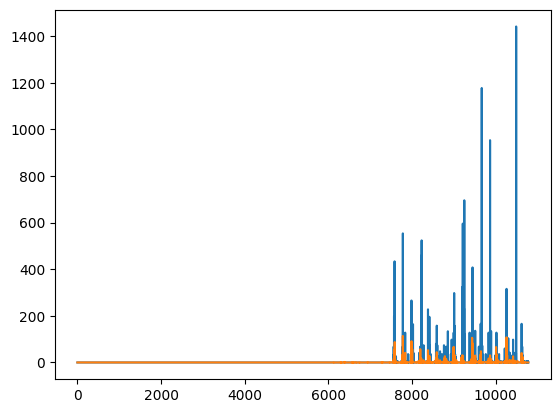

In [17]:
# 用 4,5,6,7,8 重新训练模型

params['num_iterations'] = clf_valid.best_iteration
print(clf_valid.best_iteration)
clf_test, _ = train(df_valid, df_valid, 'pay_log', params, features)

In [18]:
df_test['pay'] = np.expm1(clf_test.predict(df_test[features]))
df_test['pay'] = df_test['pay'].clip(lower=0.)
df_test['pay'].describe()

count    10780.000000
mean         0.259559
std          2.321036
min          0.000000
25%          0.016790
50%          0.030151
75%          0.127807
max         83.833492
Name: pay, dtype: float64

In [19]:
sub = pd.read_csv('result/submission_sample.csv')
sub_df = df_test[['role_id', 'pay']].copy()
sub = sub[['role_id']].merge(sub_df, on='role_id', how='left')
sub[['role_id', 'pay']].to_csv('submission.csv', index=False)